In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

In [6]:
sub = pd.read_csv('C:/Users/puneet.jindal/Downloads/meal_delivery/boxes.csv', encoding='utf-8', index_col=0)
sub['delivered_at'] = pd.to_datetime(sub['delivered_at'])
sub.head(2)

,subscription_id,box_id,delivered_at,started_week,count_boxes,product,channel
1,1000001,US3598,2013-01-14,2013-W03,1,type1,channel1
2,1000001,US3899,2013-01-21,2013-W03,2,type1,channel1


In [7]:
del_cnt = sub[['delivered_at','box_id']].groupby('delivered_at').agg('count')
del_cnt.index =pd.to_datetime(del_cnt.index)

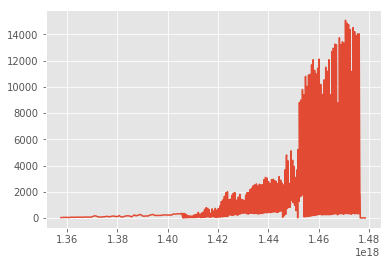

In [8]:
plt.plot(del_cnt)
plt.show()

In [9]:
last_purchase_dist = sub[['subscription_id','delivered_at','count_boxes']].groupby(['subscription_id']).agg({'delivered_at':[np.min,np.max],'count_boxes':np.max})
last_purchase_dist.head()
last_purchase_dist['purchase_gap_maxmin'] = last_purchase_dist['delivered_at']['amax'] - last_purchase_dist['delivered_at']['amin']
last_purchase_dist[last_purchase_dist['purchase_gap_maxmin'] == '0 days'].head()
# so we have approx 65% customers as repeat customers

count_boxes delivered_at            purchase_gap_maxmin
                       amax         amin       amax                    
subscription_id                                                        
1000002                   1   2013-01-28 2013-01-28              0 days
1000003                   1   2013-01-14 2013-01-14              0 days
1000006                   1   2013-01-14 2013-01-14              0 days
1000014                   1   2013-01-07 2013-01-07              0 days
1000017                   1   2013-01-07 2013-01-07              0 days

In [196]:
##last_purchase_dist = sub[['subscription_id','delivered_at','count_boxes','channel']].groupby(['subscription_id','channel']).agg({'delivered_at':[np.min,np.max],'count_boxes':np.max})
#Lets check whether a customer belongs to multiple channels
#pd.unique(pd.get_dummies(last_purchase_dist.reset_index()['channel']).sum(axis = 1))

## verify whether multiple customers 
# measuring distributon across channels
#pd.get_dummies(last_purchase_dist.reset_index()['channel']).sum(axis = 0)*100/pd.get_dummies(last_purchase_dist.reset_index()['channel']).sum(axis = 0).sum()

In [10]:
from datetime import datetime
today = datetime.today().replace(day = 7, month=11, year = 2016,hour=0,minute=0,second=0,microsecond=0)
today
last_purchase_dist['time_since_last_purchase']=last_purchase_dist['delivered_at']['amax'].apply(lambda x: today - x)

In [11]:
last_purchase_dist.head()

count_boxes delivered_at            purchase_gap_maxmin  \
                       amax         amin       amax                       
subscription_id                                                           
1000001                   3   2013-01-14 2013-01-28             14 days   
1000002                   1   2013-01-28 2013-01-28              0 days   
1000003                   1   2013-01-14 2013-01-14              0 days   
1000004                   2   2013-01-21 2013-01-28              7 days   
1000005                   3   2013-01-14 2013-01-28             14 days   

                time_since_last_purchase  
                                          
subscription_id                           
1000001                        1379 days  
1000002                        1379 days  
1000003                        1393 days  
1000004                        1379 days  
1000005                        1379 days

In [12]:
pd.DataFrame(last_purchase_dist.to_records()).columns

Index([u'subscription_id', u'('count_boxes', 'amax')',
       u'('delivered_at', 'amin')', u'('delivered_at', 'amax')',
       u'('purchase_gap_maxmin', '')', u'('time_since_last_purchase', '')'],
      dtype='object')

In [127]:
#TBD later
#df = pd.concat([last_purchase_dist, pd.get_dummies(last_purchase_dist['channel'])], axis=1)
#df.head()

In [10]:
#TBD later
#sub[['subscription_id','delivered_at']].groupby('subscription_id')['delivered_at'].apply(lambda x: list(x))

In [194]:
grouped = sub[['subscription_id','delivered_at']].groupby('subscription_id')

In [195]:
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing

def tmpFunc(df):
    return (df['subscription_id'].iloc[0],df['delivered_at'].nlargest(2).min())
    
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.DataFrame(retLst,columns=['subscription_id','2nd_last_transaction_date'])
df_temp = applyParallel(grouped, tmpFunc)

In [201]:
df_temp.set_index('subscription_id',inplace=True)

In [202]:
final_merge = pd.merge(last_purchase_dist,df_temp,how='inner',left_index=True,right_index=True)

In [203]:
final_merge.head(2)

,"(count_boxes, amax)","(delivered_at, amin)","(delivered_at, amax)","(purchase_gap_maxmin, )","(time_since_last_purchase, )",2nd_last_transaction_date
subscription_id,,,,,,
1000001,3,2013-01-14,2013-01-28,14 days,1379 days,2013-01-21
1000002,1,2013-01-28,2013-01-28,0 days,1379 days,2013-01-28


In [205]:
cancels = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/cancels.csv',encoding='utf-8')
cancels.set_index('subscription_id', inplace=True)

In [246]:
pauses = pd.read_csv('/Users/puneetjindal/Downloads/data_science_test/pauses.csv',encoding='utf-8')
pauses['pause_start'] = pd.to_datetime(pauses['pause_start'])
pauses['pause_end'] = pd.to_datetime(pauses['pause_end'])
pauses['pause_gap'] = pauses['pause_end'] - pauses['pause_start']
pauses['pause_cnt'] = pd.Series(1, index=pauses.index)
pauses.head()

,subscription_id,pause_start,pause_end,pause_gap,pause_cnt
0,1000003,2013-06-10,2013-06-16,6 days,1
1,1000003,2013-06-17,2013-06-23,6 days,1
2,1000003,2013-06-24,2013-06-30,6 days,1
3,1000009,2013-02-04,2013-02-10,6 days,1
4,1000009,2013-02-11,2013-02-17,6 days,1


In [247]:
list(pd.unique(pauses[pauses['pause_gap']!='6 days']['subscription_id']))

[1016098,
 1056841,
 1109456,
 1116541,
 1120570,
 1124078,
 1124305,
 1127590,
 1131108,
 1132356,
 1139123,
 1139303,
 1140343,
 1144456,
 1147240,
 1147327,
 1150967]

In [248]:
##commenting as of now once i get an answer from the business to take a call on the data imputation for the following subscription ids
#last_purchase_dist[last_purchase_dist.index.isin(list(pd.unique(pauses[pauses['pause_gap']!='6 days']['subscription_id'])))]

## taking the above assumption
pauses = pauses[pauses['pause_gap']!='-360 days']

In [249]:
pauses_woseasonality = pauses.groupby('subscription_id').agg({'pause_cnt':'sum'})
## adding seasonality factors later on pauses

In [250]:
print cancels.shape
print pauses_woseasonality.shape
print last_purchase_dist.shape

(313660, 3)
(228837, 1)
(395383, 5)


In [232]:
#cancels.head()
#Taking cancellation seasonality into account later. As of now taking binary of cancelation is more important

In [238]:
cancels['cancelled'] = pd.Series(1, index=cancels.index)

In [242]:
final_merge = pd.merge(final_merge,cancels,how='left',left_index=True,right_index=True)

In [252]:
final_merge = pd.merge(final_merge,pauses_woseasonality,how='left',left_index=True,right_index=True)

In [253]:
final_merge.head()
###lets rename columns to make things more simple

,"(count_boxes, amax)","(delivered_at, amin)","(delivered_at, amax)","(purchase_gap_maxmin, )","(time_since_last_purchase, )",2nd_last_transaction_date,delivery_weekday,canceled_at,cancelled,pause_cnt
subscription_id,,,,,,,,,,
1000001,3,2013-01-14,2013-01-28,14 days,1379 days,2013-01-21,3.0,2013-01-29,1.0,NaN
1000002,1,2013-01-28,2013-01-28,0 days,1379 days,2013-01-28,3.0,2013-01-30,1.0,NaN
1000003,1,2013-01-14,2013-01-14,0 days,1393 days,2013-01-14,3.0,2013-06-03,1.0,3.0
1000004,2,2013-01-21,2013-01-28,7 days,1379 days,2013-01-21,3.0,2013-01-28,1.0,NaN
1000005,3,2013-01-14,2013-01-28,14 days,1379 days,2013-01-21,3.0,2013-01-30,1.0,NaN
